In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import hashlib
import random

# ================================
# Volatile DCGAN with Expanded Color Space
# ================================
#  Global configurations (as given; do not change these)
NUM_CHANNELS = 6        # Expanded color space: 6 channels
IMAGE_SIZE = (NUM_CHANNELS, 64, 64)
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4
LATENT_DIM = 1024
NGF = 64                # Generator base channels
NDF = 32                # Discriminator base channels
GEN_DROPOUT = 0.5
DISC_DROPOUT = 0.2
NOISE_INJECTION_G = 0.3
NOISE_INJECTION_D = 0.3
LABEL_FLIP_PROB = 0.1
GRAD_CLIP = 5.0
MODEL_PATH_G = "expanded_generator_dcgan_9CHAN_GPT.pth"
MODEL_PATH_D = "expanded_discriminator_dcgan_9CHAN_GPT.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [4]:
class CSPRNGNoiseDataset(Dataset):
    """
    Generates images of size IMAGE_SIZE filled with cryptographic randomness.
    Now using NUM_CHANNELS channels.
    """
    def __init__(self, num_images=5000, image_size=IMAGE_SIZE):
        super().__init__()
        self.num_images = num_images
        self.channels, self.height, self.width = image_size
        self.num_pixels = self.channels * self.height * self.width

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        raw_bytes = os.urandom(self.num_pixels)
        # Interpret raw bytes as unsigned 8-bit integers and reshape to (channels, height, width)
        img_array = np.frombuffer(raw_bytes, dtype=np.uint8).reshape(self.channels, self.height, self.width)
        # Convert to float and normalize to [0,1]
        img_tensor = torch.tensor(img_array, dtype=torch.float32) / 255.0
        return img_tensor

def get_csprng_dataloader(batch_size=BATCH_SIZE):
    dataset = CSPRNGNoiseDataset()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

train_loader = get_csprng_dataloader()

In [5]:
class NoiseInjection(nn.Module):
    """
    Inject Gaussian noise into feature maps.
    """
    def __init__(self, scale=0.3):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.scale
            return x + noise
        return x
        
class ExpandedGeneratorNoSigmoid(nn.Module):
    """
    DCGAN-like Generator modified to output raw values without a Sigmoid.
    The output will have NUM_CHANNELS channels.
    """
    def __init__(self, latent_dim=LATENT_DIM, ngf=NGF, dropout=GEN_DROPOUT, noise_scale=NOISE_INJECTION_G):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            NoiseInjection(noise_scale),
            nn.Dropout2d(dropout),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            NoiseInjection(noise_scale),
            nn.Dropout2d(dropout),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            NoiseInjection(noise_scale),
            nn.Dropout2d(dropout),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            NoiseInjection(noise_scale),
            nn.Dropout2d(dropout),

            # Change final layer: output NUM_CHANNELS channels with linear activation.
            nn.ConvTranspose2d(ngf, NUM_CHANNELS, 4, 2, 1, bias=False)
            # No Sigmoid here, so output is unbounded (or follows the initialization's range)
        )

    def forward(self, z):
        return self.main(z)


In [6]:
class DiscriminatorInputNoise(nn.Module):
    """
    Adds random noise to the Discriminator input.
    """
    def __init__(self, scale=0.3):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.scale
            return x + noise
        return x

class ExpandedDiscriminator(nn.Module):
    """
    Discriminator modified to accept 6-channel images.
    Final convolution uses kernel_size=8 to ensure output shape is (batch,).
    """
    def __init__(self, ndf=NDF, dropout=DISC_DROPOUT):
        super().__init__()
        self.input_noise = DiscriminatorInputNoise(scale=NOISE_INJECTION_D)
        self.main = nn.Sequential(
            nn.Conv2d(NUM_CHANNELS, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout),

            # Final conv: input size should be 8x8 here, kernel_size=8 to get 1x1
            nn.Conv2d(ndf*4, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_noise(x)
        x = self.main(x)
        return x.view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [7]:
netG = ExpandedGeneratorNoSigmoid().to(DEVICE)
netD = ExpandedDiscriminator().to(DEVICE)
netG.apply(weights_init)
netD.apply(weights_init)

print("ExpandedGeneratorNoSigmoid & ExpandedDiscriminator initialized.")

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))


ExpandedGeneratorNoSigmoid & ExpandedDiscriminator initialized.


# UNCOMMENT FOR TRAINING

In [8]:
# # -------------------------------
# # Custom Initialization for Final Layer of Generator
# # (This encourages a wider spread of output values.)
# def init_final_layer_wide(model):
#     for m in model.modules():
#         if isinstance(m, nn.ConvTranspose2d):
#             # Identify the final layer by checking if its output channels equal NUM_CHANNELS
#             if m.out_channels == NUM_CHANNELS:
#                 nn.init.uniform_(m.weight, a=-0.5, b=0.5)
                
# init_final_layer_wide(netG)  # Apply custom init to netG

# # -------------------------------
# # New Uniformity Loss Function (Batch-level, L1 divergence)
# def batch_uniformity_loss(gen_output, num_bins=256):
#     """
#     Computes a loss term that penalizes deviation from a uniform distribution
#     over the pixel values in the generator's raw output.
#     The loss is the L1 distance between the normalized histogram and the uniform distribution.
    
#     Parameters:
#       gen_output (Tensor): Generator output tensor of shape (N, C, H, W) with raw (unbounded) values.
#       num_bins (int): Number of bins (default 256).
    
#     Returns:
#       Tensor: The computed uniformity loss.
#     """
#     # Flatten the generator output to 1D
#     pixels = gen_output.view(-1)
#     # Use the batch min and max to define the histogram range
#     output_min = pixels.min().item()
#     output_max = pixels.max().item()
#     # Compute histogram; add epsilon to avoid zeros
#     hist = torch.histc(pixels, bins=num_bins, min=output_min, max=output_max) + 1e-6
#     # Normalize histogram to get probability distribution
#     p = hist / hist.sum()
#     # Target uniform distribution: each bin has probability 1/num_bins
#     target = torch.full_like(p, 1.0 / num_bins)
#     # Compute L1 distance between the distributions
#     loss = torch.abs(p - target).sum()
#     return loss

# # Increase the weight of the uniformity loss
# lambda_uniform = 0.3

# # -------------------------------
# # Training Function (Using your dataloader, etc.)
# def train_expanded_dcgan(epochs=EPOCHS):
#     netG.train()
#     netD.train()
#     for epoch in range(epochs):
#         for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
#             b_size = data.size(0)
#             real_data = data.to(DEVICE)

#             # Train Discriminator
#             netD.zero_grad()
#             label_real = torch.full((b_size,), 0.9, dtype=torch.float, device=DEVICE)
#             label_fake = torch.full((b_size,), 0.0, dtype=torch.float, device=DEVICE)
#             if random.random() < LABEL_FLIP_PROB:
#                 label_real, label_fake = label_fake.clone(), label_real.clone()
#             output_real = netD(real_data)
#             errD_real = criterion(output_real, label_real)
            
#             noise = torch.randn(b_size, LATENT_DIM, 1, 1, device=DEVICE)
#             fake_data = netG(noise)
#             output_fake = netD(fake_data.detach())
#             errD_fake = criterion(output_fake, label_fake)
            
#             errD = errD_real + errD_fake
#             errD.backward()
#             nn.utils.clip_grad_norm_(netD.parameters(), GRAD_CLIP)
#             optimizerD.step()
            
#             # Train Generator (with uniformity loss)
#             netG.zero_grad()
#             label_for_g = torch.full((b_size,), 0.9, dtype=torch.float, device=DEVICE)
#             output_gen = netD(fake_data)
#             errG = criterion(output_gen, label_for_g)
            
#             # Compute uniformity loss on the raw output of the generator (no scaling)
#             uni_loss = batch_uniformity_loss(fake_data)
            
#             total_gen_loss = errG + lambda_uniform * uni_loss
#             total_gen_loss.backward()
#             nn.utils.clip_grad_norm_(netG.parameters(), GRAD_CLIP)
#             optimizerG.step()
            
#         print(f"Epoch [{epoch+1}/{epochs}], D_loss: {errD.item():.4f}, G_loss: {errG.item():.4f}, Uni_loss: {uni_loss.item():.4f}")
        
#     torch.save(netG.state_dict(), MODEL_PATH_G)
#     torch.save(netD.state_dict(), MODEL_PATH_D)
#     print(f"Saved Expanded Generator to {MODEL_PATH_G} and Discriminator to {MODEL_PATH_D}")

# train_expanded_dcgan()

# INFERENCE AND EVALUATION

In [9]:
def load_expanded_generator(model_path=MODEL_PATH_G):
    gen = ExpandedGeneratorNoSigmoid().to(DEVICE)
    gen.load_state_dict(torch.load(model_path, map_location=DEVICE))
    gen.eval()
    return gen

def generate_expanded_images(gen, n_images=10):
    gen.eval()
    images = []
    with torch.no_grad():
        for _ in range(n_images):
            z = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
            fake_img = gen(z)
            images.append(fake_img.cpu())
    return images

def extract_random_bytes_float_no_sigmoid(images, final_bytes=1024, repeated_hashes=2):
    """
    1. Convert each image to raw float32 bytes (without scaling).
    2. Repeatedly hash the result to remove any structure.
    """
    all_bytes = bytearray()
    for img in images:
        # Directly convert the float32 tensor to bytes.
        arr = img.squeeze().detach().cpu().numpy().astype(np.float32)
        all_bytes.extend(arr.tobytes())
    
    hash_output = bytes(all_bytes)
    # for _ in range(repeated_hashes):
    #     xof_output = hashlib.shake_256(data).digest(final_bytes)
    #     print(len(xof_output))
    
    return hash_output[:final_bytes]


def generate_one_random_byte_excluding_mode_csprng(exclude_val, max_tries=100):
    """
    Generates a single random byte using os.urandom that is NOT equal to exclude_val.
    Retries up to max_tries times.
    """
    for _ in range(max_tries):
        rand_byte = os.urandom(1)[0]
        if rand_byte != exclude_val:
            return rand_byte
    # Fallback if all tries produce the exclude value
    return np.random.randint(0, 256)

def smart_replace_mode_csprng(data, exclude_val, fraction):
    """
    Replace a computed number of occurrences of the mode (exclude_val) in one pass
    using os.urandom for replacements.
    
    Parameters:
      data (bytes): The input byte sequence.
      exclude_val (int): The mode value to replace.
      fraction (float): Fraction of occurrences to replace.
    
    Returns:
      (bytes, int): The modified data and the number of replacements made.
    """
    # Convert data to a mutable bytearray
    data_array = bytearray(data)
    # Find all indices where the byte equals exclude_val
    indices = [i for i, b in enumerate(data_array) if b == exclude_val]
    n_occurrences = len(indices)
    if n_occurrences == 0:
        return data, 0
    
    n_to_replace = int(n_occurrences * fraction)
    if n_to_replace <= 0:
        return data, 0
    
    # Randomly select indices to replace
    replace_indices = np.random.choice(indices, size=n_to_replace, replace=False)
    replacements = 0
    for idx in replace_indices:
        new_val = generate_one_random_byte_excluding_mode_csprng(exclude_val)
        data_array[idx] = new_val
        replacements += 1
        
    return bytes(data_array), replacements

def smart_reduce_mode_frequency_csprng(data, fraction=0.5, tolerance=0.2, verbose=True):
    """
    Iteratively reduces the mode frequency by replacing occurrences (using os.urandom)
    until the mode's frequency is within ±20% of the average frequency.
    That is, the mode frequency should be between 0.8*avg and 1.2*avg.
    
    Parameters:
      data (bytes): Input byte sequence.
      fraction (float): Fraction of mode occurrences to replace each iteration.
      tolerance (float): Tolerance as a fraction (0.2 = ±20%).
      verbose (bool): If True, print iteration details.
    
    Returns:
      (bytes, int): The final modified data and total replacements made.
    """
    data_out = data
    total_len = len(np.frombuffer(data_out, dtype=np.uint8))
    avg = total_len / 256.0
    lower_bound = (1 - tolerance) * avg
    upper_bound = (1 + tolerance) * avg
    
    total_replacements = 0
    iteration = 0
    while True:
        arr = np.frombuffer(data_out, dtype=np.uint8)
        counts = np.bincount(arr, minlength=256)
        mode_val = int(np.argmax(counts))
        mode_freq = counts[mode_val]
        if verbose:
            print(f"Iteration {iteration}: Mode {mode_val} frequency = {mode_freq:.2f} (avg = {avg:.2f}, bounds = [{lower_bound:.2f}, {upper_bound:.2f}])")
        if lower_bound <= mode_freq <= upper_bound:
            break
        data_out, replacements = smart_replace_mode_csprng(data_out, mode_val, fraction)
        total_replacements += replacements
        iteration += 1
        if verbose:
            print(f"  Replaced {replacements} occurrences of {mode_val}")
    print(f"Final mode frequency: {mode_freq} (target: between {lower_bound:.2f} and {upper_bound:.2f}).")
    print(f"Total replacements made: {total_replacements}")
    return data_out, total_replacements

def most_frequent_bin(data):
    """
    Given a byte sequence 'data', finds the most frequent byte value (0-255)
    and returns the byte value and its count.
    """
    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    max_bin = int(np.argmax(counts))
    max_count = counts[max_bin]
    return max_bin, max_count

# -------------------------------
# Example Usage:
# Assume expanded_random_bytes is your original GAN-generated output bytes.
# (For demonstration, replace with your variable containing the byte data.)
# Also assume that expanded_random_bytes is already defined.


# ================================
# Example usage:
expandedG_loaded = load_expanded_generator(MODEL_PATH_G)
expanded_images = generate_expanded_images(expandedG_loaded, n_images=10000)

expanded_random_bytes = extract_random_bytes_float_no_sigmoid(expanded_images, final_bytes= int(1000000), repeated_hashes=1)

max_value, frequency = most_frequent_bin(expanded_random_bytes)
max_byte = bytes([max_value])
# Example usage:
# Let's assume 'extracted_bytes' is your byte data from the GAN or CSPRNG.
# print(f"Most frequent bin: {max_value} with frequency: {frequency} before replacement")

# while frequency > 5000:
# for i in range(4):
    # max_byte = bytes([max_value])
    # print(f"Most frequent bin: {max_value} with frequency: {frequency}")
# randomised_expanded_random_bytes = iterative_reduce_spike_csprng(randomised_expanded_random_bytes, target=max_byte)

# randomised_expanded_random_bytes, total_repl = smart_reduce_mode_frequency(expanded_random_bytes, expandedG_loaded, DEVICE, LATENT_DIM, tolerance=0.2)

    # max_value, frequency = most_frequent_bin(randomised_expanded_random_bytes)

print("Before replacement:")
mode_val, freq = most_frequent_bin(expanded_random_bytes)
print(f"Most frequent bin: {bytes([mode_val])} with frequency: {freq}")

randomised_expanded_random_bytes, total_repl = smart_reduce_mode_frequency_csprng(
    data=expanded_random_bytes,
    fraction=0.5,    # Replace 50% of mode occurrences each iteration
    tolerance=0.42    # Mode frequency must be within ±20% of average frequency
)

mode_val_final, freq_final = most_frequent_bin(randomised_expanded_random_bytes)
print("After replacement:")
print(f"Most frequent bin: {bytes([mode_val_final])} with frequency: {freq_final}")
print(f"Total replacements made: {total_repl} out of {len(expanded_random_bytes)} bytes.")
print("First 16 random bytes from modified data:", randomised_expanded_random_bytes[:16])


# print("First 16 random bytes from Expanded GAN:", randomised_expanded_random_bytes[:16])


Before replacement:
Most frequent bin: b'@' with frequency: 203993
Iteration 0: Mode 64 frequency = 203993.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 101996 occurrences of 64
Iteration 1: Mode 64 frequency = 101997.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 50998 occurrences of 64
Iteration 2: Mode 64 frequency = 50999.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 25499 occurrences of 64
Iteration 3: Mode 65 frequency = 29230.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 14615 occurrences of 65
Iteration 4: Mode 64 frequency = 25553.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 12776 occurrences of 64
Iteration 5: Mode 63 frequency = 19946.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 9973 occurrences of 63
Iteration 6: Mode 65 frequency = 14696.00 (avg = 3906.25, bounds = [2265.63, 5546.88])
  Replaced 7348 occurrences of 65
Iteration 7: Mode 64 frequency = 12844.00 (avg = 3906.25, bounds = [2265.63, 5

In [10]:
def most_frequent_bin(data):
    """
    Given a byte sequence 'data', finds the most frequent byte value (0-255)
    and returns the bin (byte value) and its count.
    """
    # Convert the byte sequence to a NumPy array of type uint8
    arr = np.frombuffer(data, dtype=np.uint8)
    # Count the frequency of each byte (0-255)
    counts = np.bincount(arr, minlength=256)
    # Find the index (bin) with the maximum count
    max_bin = np.argmax(counts)
    max_count = counts[max_bin]
    return max_bin, max_count

# Example usage:
# Let's assume 'extracted_bytes' is your byte data from the GAN or CSPRNG.
max_value, frequency = most_frequent_bin(randomised_expanded_random_bytes)
print(f"Most frequent bin: {max_value} with frequency: {frequency}")


Most frequent bin: 191 with frequency: 5467


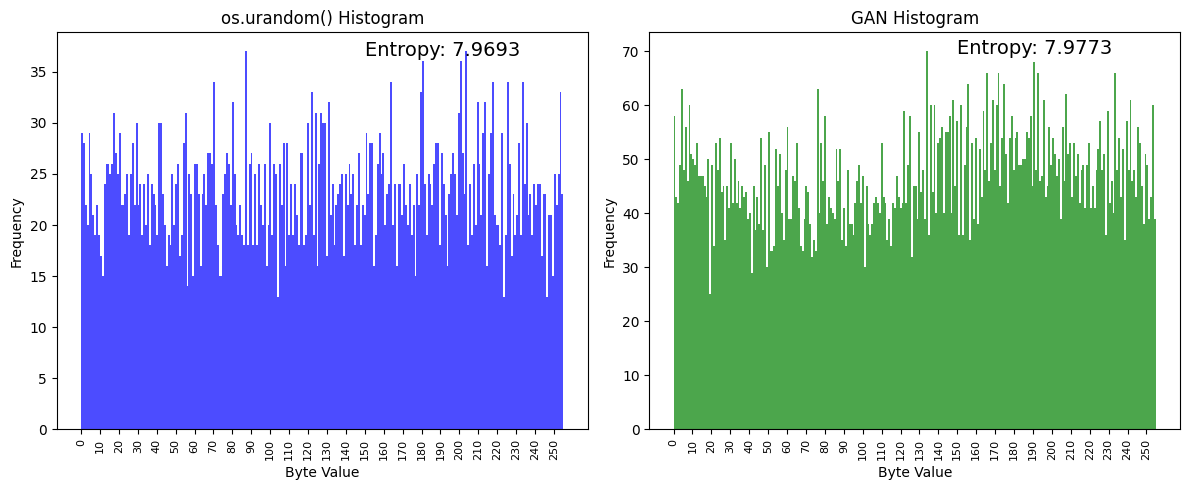

In [81]:
num_bytes = 6000

import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.ma import size
from scipy.stats import ks_1samp, entropy, chi2_contingency, uniform
from numpy.fft import fft
numgan = num_bytes *2

def shannon_entropy(data):
    """Calculate Shannon entropy (in bits per byte) of a byte sequence."""
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    probabilities = counts / float(len(data))
    probabilities = probabilities[np.nonzero(probabilities)]
    ent = -np.sum(probabilities * np.log2(probabilities))
    return ent
import os
import numpy as np
import matplotlib.pyplot as plt
import secrets
from scipy.stats import entropy

def shannon_entropy(data):
    """Calculate Shannon entropy (in bits per byte) of a byte sequence."""
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    probabilities = counts / float(len(data))
    probabilities = probabilities[np.nonzero(probabilities)]
    ent = -np.sum(probabilities * np.log2(probabilities))
    return ent

def plot_histogram_compare(data1, data2, label1="CSPRNG", label2="GAN"):
    """Plot histograms side-by-side for two byte datasets and display Shannon entropy."""
    entropy1 = shannon_entropy(data1)
    entropy2 = shannon_entropy(data2)
    
    plt.figure(figsize=(12, 5))
    
    # Plot CSPRNG histogram
    plt.subplot(1, 2, 1)
    arr1 = np.frombuffer(data1, dtype=np.uint8)
    plt.hist(arr1, bins=256, range=(0, 255), color='blue', alpha=0.7)
    plt.title(f"{label1} Histogram")
    plt.xlabel("Byte Value")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(0, 255, 10), rotation=90, size=8)
    plt.text(150, max(np.histogram(arr1, bins=256, range=(0,255))[0]) - 0.5, 
             f"Entropy: {entropy1:.4f}", fontsize=14, color='black')

    # Plot GAN histogram
    plt.subplot(1, 2, 2)
    arr2 = np.frombuffer(data2, dtype=np.uint8)
    plt.hist(arr2, bins=256, range=(0, 255), color='green', alpha=0.7)
    plt.title(f"{label2} Histogram")
    plt.xlabel("Byte Value")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(0, 255, 10), rotation=90, size=8)
    plt.text(150, max(np.histogram(arr2, bins=256, range=(0,255))[0]) -0.5,
             f"Entropy: {entropy2:.4f}", fontsize=14, color='black')

    plt.tight_layout()
    plt.show()

# -------------------------------
# Generate Data for Evaluation
# -------------------------------
csprng_sample = os.urandom(num_bytes)  # CSPRNG sample

# Securely select `num_bytes` random indices without replacement
random_indices = secrets.SystemRandom().sample(range(len(randomised_expanded_random_bytes)), numgan)

# Convert selected bytes to a `bytes` object
gan_sample = bytes(randomised_expanded_random_bytes[i] for i in random_indices)

# -------------------------------
# Run Evaluations
# -------------------------------
plot_histogram_compare(csprng_sample, gan_sample, label1="os.urandom()", label2="GAN")




In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_1samp, chisquare, uniform
from numpy.fft import fft

def ks_test_uniform(data):
    """
    Perform the KS test comparing the sample distribution to a uniform distribution.
    Data is first normalized to [0,1] from its byte values.
    """
    # Convert bytes to numpy array of uint8, then cast to float32 and normalize
    data_norm = np.frombuffer(data, dtype=np.uint8).astype(np.float32) / 255.0
    # Use uniform.cdf from scipy.stats as the target CDF
    statistic, p_value = ks_1samp(data_norm, uniform.cdf)
    return statistic, p_value
    
def chi_square_test(data, epsilon=1e-6):
    """
    Perform a Chi-Square test comparing the observed frequency distribution 
    of the byte data to the expected uniform distribution.
    
    Both the observed and expected counts are adjusted by a small epsilon so that
    their sums match exactly.
    """
    # Get observed counts and add epsilon to each bin.
    observed = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256) + epsilon
    # Expected count per bin is total length divided by 256, adjusted with epsilon.
    expected = np.full(256, len(data)/256.0) + epsilon
    chi2_stat, p_value = chisquare(observed, f_exp=expected)
    return chi2_stat, p_value

def autocorrelation(data, lag=1):
    """
    Compute normalized autocorrelation for the byte data.
    A value near 0 indicates little correlation between successive bytes.
    """
    data_arr = np.frombuffer(data, dtype=np.uint8).astype(np.float32)
    n = len(data_arr)
    mean = np.mean(data_arr)
    c0 = np.sum((data_arr - mean) ** 2) / n
    c1 = np.sum((data_arr[:n-lag] - mean) * (data_arr[lag:] - mean)) / n
    return c1 / c0

def bitwise_balance(data):
    """
    Compute the bitwise balance: returns the total number of zeros and ones 
    in the binary representation of the data. In truly random data, these should be nearly equal.
    """
    bits = np.unpackbits(np.frombuffer(data, dtype=np.uint8))
    total_bits = len(bits)
    ones = np.sum(bits)
    zeros = total_bits - ones
    return zeros, ones

def frequency_spectrum(data, title="Frequency Spectrum"):
    """
    Compute and plot the frequency spectrum (via FFT) of the byte data.
    A flat spectrum suggests a lack of hidden periodic structures.
    """
    data_arr = np.frombuffer(data, dtype=np.uint8)
    spectrum = np.abs(fft(data_arr))
    plt.figure(figsize=(10, 4))
    plt.plot(spectrum[:len(spectrum)//2])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()


# -------------------------------
# Example usage (assuming gan_sample is defined):
# Let's say gan_sample is your GAN-generated data as bytes.
# (Replace gan_sample with your variable holding the generated bytes.)


In [84]:
import os
import numpy as np

# Assume these functions are already defined: ks_test_uniform, chi_square_test, autocorrelation, bitwise_balance, frequency_spectrum

# Generate GAN-based random sample
num_bytes = 100  # Adjust as needed
gan_sample = randomised_expanded_random_bytes[:num_bytes]

# Generate CSPRNG-based random sample
csprng_sample = np.frombuffer(os.urandom(num_bytes), dtype=np.uint8)

# KS Test
gan_ks_stat, gan_ks_p = ks_test_uniform(gan_sample)
csprng_ks_stat, csprng_ks_p = ks_test_uniform(csprng_sample)

# Chi-Square Test
gan_chi2_stat, gan_chi2_p = chi_square_test(gan_sample)
csprng_chi2_stat, csprng_chi2_p = chi_square_test(csprng_sample)

# Autocorrelation (lag=1)
gan_auto_corr = autocorrelation(gan_sample)
csprng_auto_corr = autocorrelation(csprng_sample)

# Bitwise Balance
gan_zeros, gan_ones = bitwise_balance(gan_sample)
csprng_zeros, csprng_ones = bitwise_balance(csprng_sample)

# Print Results
print("\n--- Comparative Analysis of Randomness Tests ---\n")
print(f"{'Test':<30} {'GAN':<30} {'CSPRNG (urandom)':<30}")
print("-" * 90)
print(f"{'KS Test Statistic':<30} {gan_ks_stat:.4f} (p={gan_ks_p:.4f})   {csprng_ks_stat:.4f} (p={csprng_ks_p:.4f})")
print(f"{'Chi-Square Test Statistic':<30} {gan_chi2_stat:.4f} (p={gan_chi2_p:.4f})   {csprng_chi2_stat:.4f} (p={csprng_chi2_p:.4f})")
print(f"{'Autocorrelation (lag=1)':<30} {gan_auto_corr:.4f}                         {csprng_auto_corr:.4f}")
print(f"{'Bitwise Balance (Zeros)':<30} {gan_zeros}                           {csprng_zeros}")
print(f"{'Bitwise Balance (Ones)':<30} {gan_ones}                             {csprng_ones}")

# # Plot Frequency Spectrums
# frequency_spectrum(gan_sample, title="GAN Frequency Spectrum")
# frequency_spectrum(csprng_sample, title="CSPRNG (urandom) Frequency Spectrum")



--- Comparative Analysis of Randomness Tests ---

Test                           GAN                            CSPRNG (urandom)              
------------------------------------------------------------------------------------------
KS Test Statistic              0.0959 (p=0.2975)   0.1145 (p=0.1343)
Chi-Square Test Statistic      227.6794 (p=0.8899)   253.2794 (p=0.5187)
Autocorrelation (lag=1)        0.0334                         0.0993
Bitwise Balance (Zeros)        420.0                           383.0
Bitwise Balance (Ones)         380                             417
